In [3]:
import warnings
import itertools
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

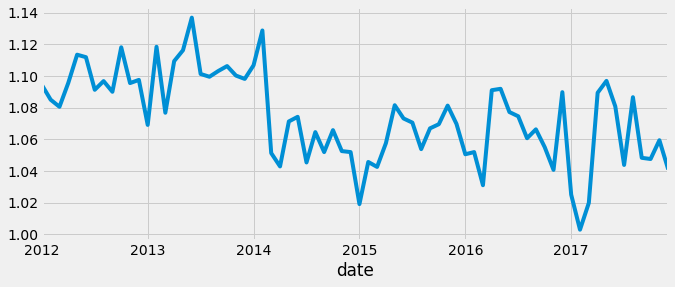

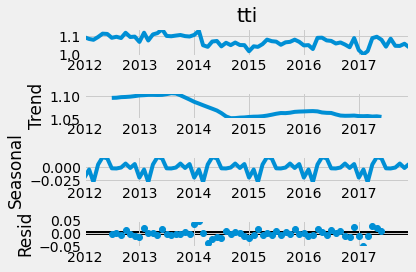

In [4]:
data = pd.read_csv('fpmtti6.csv', index_col=0, parse_dates=True, infer_datetime_format=True)
y = data.tti

y.plot(figsize=(10,4))
plt.show()

from statsmodels.tsa.seasonal import seasonal_decompose
result = seasonal_decompose(y)
fig = result.plot()

Examples of parameter combinations for Seasonal ARIMA...
SARIMAX: (0, 0, 1) x (0, 0, 1, 12)
SARIMAX: (0, 0, 1) x (0, 1, 0, 12)
SARIMAX: (0, 1, 0) x (0, 1, 1, 12)
SARIMAX: (0, 1, 0) x (1, 0, 0, 12)
ARIMA(0, 0, 0)x(0, 0, 0, 12) - AIC:213.7033807602043
ARIMA(0, 0, 0)x(0, 0, 1, 12) - AIC:179.89231154877322
ARIMA(0, 0, 0)x(0, 1, 0, 12) - AIC:-239.29464858877557
ARIMA(0, 0, 0)x(0, 1, 1, 12) - AIC:-187.05838161325937
ARIMA(0, 0, 0)x(1, 0, 0, 12) - AIC:-247.15070839599832
ARIMA(0, 0, 0)x(1, 0, 1, 12) - AIC:-261.3781883921749
ARIMA(0, 0, 0)x(1, 1, 0, 12) - AIC:-191.56417745908803
ARIMA(0, 0, 0)x(1, 1, 1, 12) - AIC:-186.35163568983117
ARIMA(0, 0, 1)x(0, 0, 0, 12) - AIC:123.2030685150116
ARIMA(0, 0, 1)x(0, 0, 1, 12) - AIC:104.64516757165595
ARIMA(0, 0, 1)x(0, 1, 0, 12) - AIC:-248.5888595018368
ARIMA(0, 0, 1)x(0, 1, 1, 12) - AIC:-196.87549142722884
ARIMA(0, 0, 1)x(1, 0, 0, 12) - AIC:-258.08109093122664
ARIMA(0, 0, 1)x(1, 0, 1, 12) - AIC:-268.0576367354928
ARIMA(0, 0, 1)x(1, 1, 0, 12) - AIC:-206.60

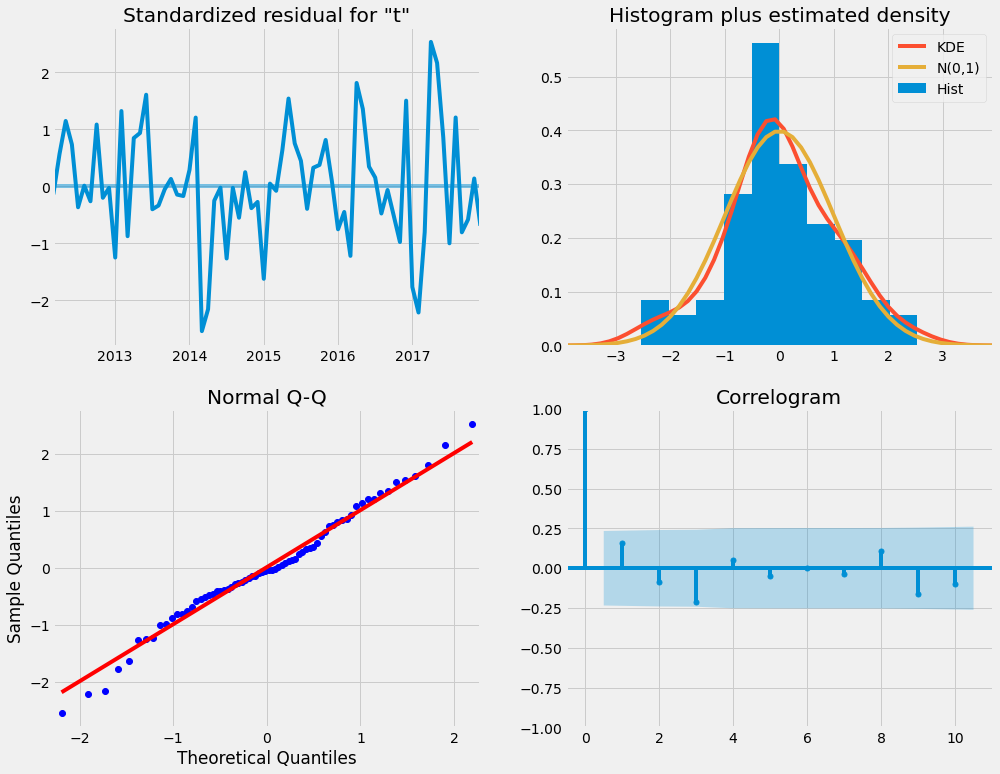

In [5]:
# Define the p, d and q parameters to take any value between 0 and 2
p = d = q = range(0, 2)

# Generate all different combinations of p, q and q triplets
pdq = list(itertools.product(p, d, q))

# Generate all different combinations of seasonal p, q and q triplets
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

print('Examples of parameter combinations for Seasonal ARIMA...')
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1]))
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[2]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[3]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[4]))

#select best model
warnings.filterwarnings("ignore") # specify to ignore warning messages
AIC_list = pd.DataFrame({}, columns=['param','param_seasonal','AIC'])
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(y,
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)

            results = mod.fit()

            print('ARIMA{}x{} - AIC:{}'.format(param, param_seasonal, results.aic))
            temp = pd.DataFrame([[ param ,  param_seasonal , results.aic ]], columns=['param','param_seasonal','AIC'])
            AIC_list = AIC_list.append( temp, ignore_index=True)  
            del temp

        except:
            continue

m = np.amin(AIC_list['AIC'].values) # Find minimum value in AIC
l = AIC_list['AIC'].tolist().index(m) # Find index number for lowest AIC
Min_AIC_list = AIC_list.iloc[l,:]



mod = sm.tsa.statespace.SARIMAX(y,
                                order=Min_AIC_list['param'],
                                seasonal_order=Min_AIC_list['param_seasonal'],
                                enforce_stationarity=False,
                                enforce_invertibility=False)
results = mod.fit()

print("### Min_AIC_list ### \n{}".format(Min_AIC_list))

print(results.summary().tables[1])

results.plot_diagnostics(figsize=(15, 12))
plt.show()


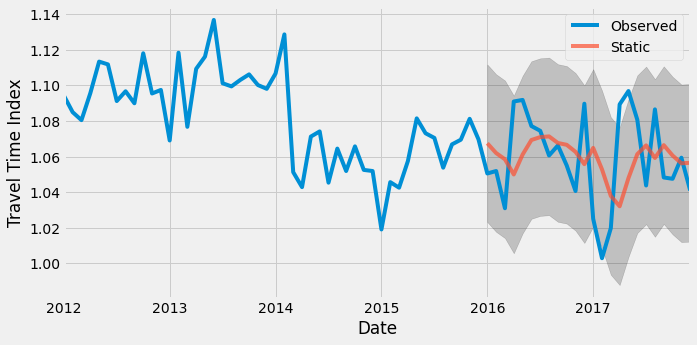

In [6]:
#one-step ahead forecasts
pred = results.get_prediction(start=pd.to_datetime('2016-01-01'), dynamic=False)
pred_ci = pred.conf_int()

#plot the real and forecasted values
ax = y['2012':].plot(label='Observed',figsize=(10,5))
pred.predicted_mean.plot(ax=ax, label='Static', alpha=.7)

ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)

ax.set_xlabel('Date')
ax.set_ylabel('Travel Time Index')
plt.legend()

plt.show()

In [10]:
import math

#quantify the accuracy of our forecasts
y_forecasted = pred.predicted_mean
y_truth = y['2016-01-01':]

# Compute RMSE
mse = ((y_forecasted - y_truth) ** 2).mean()
rmse = math.sqrt(mse)
print('RMSE is {}'.format(round(mse, 6)))

# Get forecast 12 steps ahead in future
pred_uc = results.get_forecast(steps=12)

# Get confidence intervals of forecasts
pred_ci = pred_uc.conf_int()

pred_uc.predicted_mean
#predtti=pred_uc.predicted_mean['2018':]
#predtti.to_csv("predtti.csv", index=True, header=True)

RMSE is 0.00076


2018-01-01    1.051417
2018-02-01    1.050804
2018-03-01    1.050191
2018-04-01    1.049579
2018-05-01    1.048967
2018-06-01    1.048355
2018-07-01    1.047744
2018-08-01    1.047133
2018-09-01    1.046523
2018-10-01    1.045913
2018-11-01    1.045303
2018-12-01    1.044693
Freq: MS, Name: predicted_mean, dtype: float64